In [2]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from scipy.optimize import brentq

# Méthode de la bissection #

In [3]:
def methode_bissection(f, a, b, tol=1e-10, max_iter=1000):
    fa = f(a)
    fb = f(b)
    racine_n = [] # Liste de l'estimation à chaque itération pour évaluer convergence (présent dans chaque méthode)

    if fa * fb >= 0:
        raise ValueError("f(a) et f(b) doivent avoir des signes opposés")

    for i in range(max_iter):
        m = (a + b) / 2
        fm = f(m)
        racine_n.append(m)

        if abs(fm) < tol:
            return m, i+1, racine_n
        if fm * fa < 0:
            b = m
        else:
            a = m
            fa = fm

    raise RuntimeError("Nombre d'itérations maximum atteint sans convergence (Dichotomie)")

    

# Méthode de la sécante #

In [4]:
def methode_secante(f, a, b, tol=1e-10, max_iter=1000):
    fa = f(a)
    fb = f(b)
    racine_n = []

    for i in range(max_iter):
        if fb == fa:
            raise ZeroDivisionError("Les points initiaux doivent être différents")

        # Formule de la sécante
        s = b - fb * ((b-a)/(fb-fa))
        fs = f(s)
        racine_n.append(s)

        if abs(fs) < tol:
            return s, i+1, racine_n  # Racine trouvée

        # Mise à jour des variables pour l'itération suivante
        a, fa = b, fb
        b, fb = s, fs

    raise RuntimeError("Nombre d'itérations maximum atteint sans convergence (Sécante)")

# Méthode de Dekker #

In [5]:
def methode_dekker(f, a, b, tol=1e-10, max_iter=1000):
    fa = f(a)
    fb = f(b)
    racine_n = []

    if f(a) * f(b) >= 0:
        raise Exception("Les valeurs aux bornes choisies ne sont pas de signes opposés")
    
    # Échange a et b, car b doit représenté la meilleure approximation de la racine
    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    # Définition variables
    c = a 
    fc = fa
    
    for i in range(max_iter):
        
        # Calcul de m avec la méthode de bissection
        m = (a + b) / 2

        # Calcul de s avec la méthode de la sécante en s'assurant de ne pas avoir de division par 0
        if abs(fb - fc) > 1e-14:
            s = b - fb * ((b-c)/(fb-fc))
        else:
            s = m
        
        # Pour que s soit accepté, s doit se trouver entre m et b, aussi non on utilise m
        if (s-b)*(s-m) >= 0:
            s = m
        
        fs = f(s)
        racine_n.append(s)

        if abs(fs) < tol:
            return s, i+1, racine_n
        
        # Définir b_k-1
        c = b
        fc = fb

        # Choix du nouveau contrepoint afin que f(a+1) et f(b+1) soient de signes opposés
        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        # S'assure que b est la meilleure approximation de la racine
        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa
        

    raise RuntimeError("Nombre d'itérations maximum atteint sans convergence (Dekker)")

# Méthode de Brent #

In [6]:
def methode_brent(f, a, b, tol=1e-10, max_iter=1000):
    fa = f(a)
    fb = f(b)
    racine_n = []

    if f(a) * f(b) >= 0:
        raise Exception("Les valeurs aux bornes choisies ne sont pas de signes opposés")
    
    # Échange a et b, car b doit représenté la meilleure approximation de la racine
    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    # Définition variables
    c = b 
    fc = b
    d = 0
    
    # Paramètre déterminant si la méthode de dichotomie ou d'interpolation a été retenue précédemment
    dicho = True

    for i in range(max_iter):
        # Calcul de s avec interpolation quadratique inverse ou avec méthode des sécantes
        if fa != fb and fa != fc and fb != fc:
            R = fb / fc
            S = fb / fa
            T = fa / fc
            P = S*(T*(R-T)*(c-b) - (1-R)*(b-a))
            Q = (T-1)*(R-1)*(S-1)
            pq = P/Q
            s = b + pq
            quad = True 
        else:
            s = b - fb * ((b-a)/(fb-fa))
            quad = False
         
        # Conditions pour utiliser le point milieu calculé avec la méthode de dichotomie plutôt que s calculé avec l'interpolation
        # Certaines conditions dépendent de la méthode utilisée à l'itération précedente soit le paramètre dicho
        cond1 = (s - (3*a + b)/4)*(s - b) >= 0
        cond2 = dicho and abs(s - b) >= 0.5*abs(b - c)
        cond3 = not dicho and abs(s - b) >= 0.5*abs(c - d)
        cond_quad = quad and abs(pq) >= 0.75*abs(c-b) # Condition pour IQI: |P/Q| < 3/4 |c-b| (évite un pas trop grand)
        
        if cond_quad:
            s = (a + b)/2
            dicho = True

        elif cond1 or cond2 or cond3:
            s = (a + b)/2
            dicho = True

        else:
            dicho = False

        fs = f(s) 
        racine_n.append(s)

        if abs(fs) < tol: # Racine trouvée
            return s, i+1, racine_n 

        # Modification variable pour prochaine itération
        d = c
        c = b
        fc = fb
        
        # Choix du nouveau contrepoint afin que f(a+1) et f(b+1) soient de signes opposés
        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        # S'assure que b est la meilleure approximation de la racine
        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa

    raise RuntimeError("Nombre d'itérations maximum atteint sans convergence (Brent)")

# Spline Cubique #

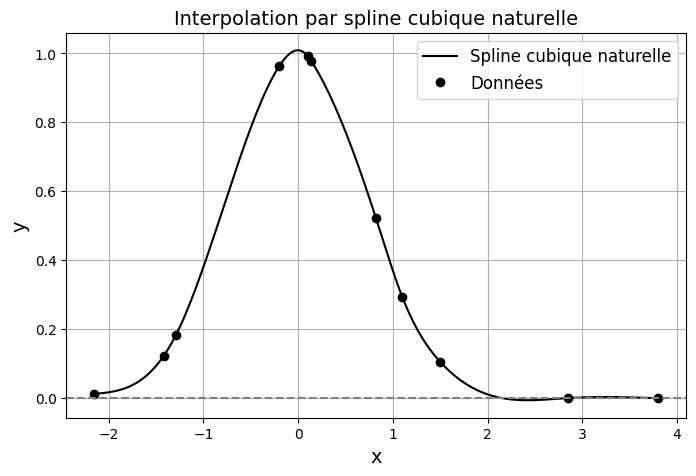

In [7]:
x = np.array([-2.15, -1.42, -1.29, -0.2, 0.1, 0.14, 0.82, 1.1, 1.5, 2.85, 3.8])
y = np.array([0.012335, 0.122439, 0.183396, 0.962973, 0.992804, 0.977224, 0.523455, 0.293345, 0.105332, 0.000394, 0.0000014])

x_interp = np.linspace(np.min(x), np.max(x), 200)
# Spline naturelle: bc_type="natural"
cubic_spline = CubicSpline(x, y, bc_type="natural")

plt.figure(figsize=(8, 5))
plt.plot(x_interp, cubic_spline(x_interp), 'k', label='Spline cubique naturelle')
plt.plot(x, y, 'ko', label='Données')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Interpolation par spline cubique naturelle", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend(loc="best", prop={'size': 12})
plt.grid(True)
plt.show()


# Résultats - Convergence et Précision #

                Racine trouvée Nombre d'itérations       Temps d'éxecution  \
Dichotomie   2.158176407217979                  26  0.00038049998693168163   
Sécante      2.158176406584893                   9  0.00018069997895509005   
Dekker       2.158176406193377                   8  0.00021520000882446766   
Brent       2.1581764061662834                   7  0.00017079999088309705   

                     Écart relatif  
Dichotomie  4.8730773840587336e-08  
Sécante     1.9396469831107594e-08  
Dekker       1.255406305783921e-09  
Brent        2.057705795417015e-14  


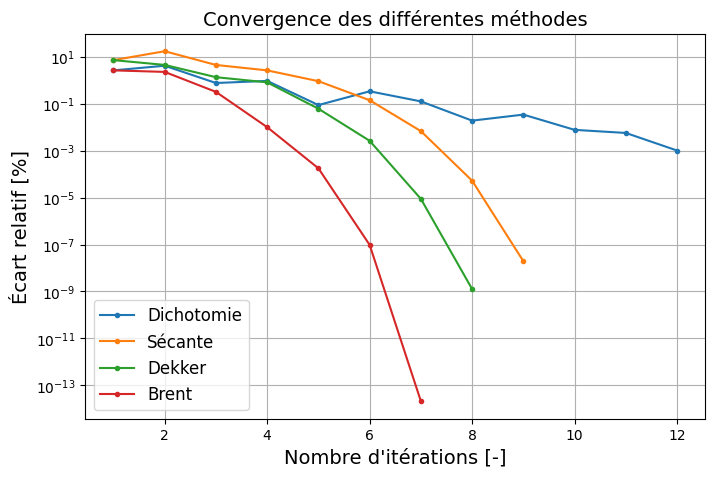



               Racine trouvée Nombre d'itérations       Temps d'éxecution  \
Dichotomie  2.826723718643188                  22  0.00016530000721104443   
Sécante     2.826723715791775                   5    8.13000078778714e-05   
Dekker      2.826723715791775                   5   7.989999721758068e-05   
Brent       2.826723715796209                   5   9.210000280290842e-05   

                     Écart relatif  
Dichotomie  1.0086529764251262e-07  
Sécante      8.122269615874137e-12  
Dekker       8.122269615874137e-12  
Brent        1.487302252485115e-10  


In [12]:
# Test pour les différentes méthodes à partie de la spline

# Première racine avec intervalle (1.8, 2.4)
ref = brentq(cubic_spline, 1.8, 2.4, xtol=1e-20)

liste_fct = [methode_bissection, methode_secante, methode_dekker, methode_brent]
noms = ["Dichotomie", "Sécante", "Dekker", "Brent"]
racines = []
temps_exec = []
nb_iter = []
ecart_rel = []
convergence = []

for fct in liste_fct:
    debut = perf_counter()
    racine, n, conv = fct(cubic_spline, 1.8, 2.4)
    fin = perf_counter()
    temps = fin - debut
    ecart = (abs(racine-ref) / ref) * 100
    
    racines.append(f"{racine}")
    nb_iter.append(f"{n}")
    temps_exec.append(f"{temps}")
    ecart_rel.append(f"{ecart}")
    convergence.append(conv)

data = {
    "Racine trouvée": racines,
    "Nombre d'itérations": nb_iter,
    "Temps d'éxecution": temps_exec,
    "Écart relatif": ecart_rel,
}

df = pd.DataFrame(data, index=noms)

print(df)
conv_relative = []
for liste in convergence:
    conv_relative.append((np.abs(np.array(liste)-ref) / ref) * 100)


max_iter = 12
iteration = np.arange(1, max_iter+1)

# Graphique convergence des méthodes
plt.figure(figsize=(8, 5))
plt.plot(iteration, conv_relative[0][:max_iter], '.-', label='Dichotomie')
plt.plot(np.arange(1, len( conv_relative[1])+1), conv_relative[1], '.-', label='Sécante')
plt.plot(np.arange(1, len( conv_relative[2])+1), conv_relative[2], '.-', label='Dekker')
plt.plot(np.arange(1, len( conv_relative[3])+1), conv_relative[3], '.-', label='Brent')
plt.axhline(0, color='gray', linestyle='--')
plt.yscale("log")
plt.title("Convergence des différentes méthodes", fontsize=14)
plt.xlabel("Nombre d'itérations [-]", fontsize=14)
plt.ylabel("Écart relatif [%]", fontsize=14)
plt.legend(loc="best", prop={'size': 12})
plt.grid(True)
plt.show()



# Deuxième racine avec intervalle plus petit (2.7, 2.9)
ref2 = brentq(cubic_spline, 2.7, 2.9, xtol=1e-20)

racines2 = []
temps_exec2 = []
nb_iter2 = []
ecart_rel2 = []
convergence2 = []

for fct in liste_fct:
    debut = perf_counter()
    racine, n, conv = fct(cubic_spline, 2.7, 2.9)
    fin = perf_counter()
    temps = fin - debut
    ecart = (abs(racine-ref2) / ref2) * 100
    
    racines2.append(f"{racine}")
    nb_iter2.append(f"{n}")
    temps_exec2.append(f"{temps}")
    ecart_rel2.append(f"{ecart}")
    convergence2.append(conv)

data2 = {
    "Racine trouvée": racines2,
    "Nombre d'itérations": nb_iter2,
    "Temps d'éxecution": temps_exec2,
    "Écart relatif": ecart_rel2,
}

df2 = pd.DataFrame(data2, index=noms)

print(f"\n\n{df2}")

# Résultats - Stabilité et Robustesse #

In [15]:
def f1(x):
    return (x-1)**2

def f2(x):
    return (x-1)**5

def f3(x):
    return np.cos(2*np.pi*x)

def f4(x):
    return 2 * x**2 - x - 1

# Bornes qui ne sont pas de signes opposés
print("Bornes même signe:")
print(methode_secante(f1, 0, 1.5)[0])
# Autres méthodes ne fontionnent pas, car les bornes n'ont pas de signes opposés


# Fonction plate près de la racine
liste_fct = [methode_bissection, methode_secante, methode_dekker, methode_brent]
noms = ["Dichotomie", "Sécante", "Dekker", "Brent"]
racines = []
nb_iter = []
convergence = []

for fct in liste_fct:
    racine, n, conv = fct(f2, -3, 4)
    
    
    racines.append(f"{racine}")
    nb_iter.append(f"{n}")
    convergence.append(conv)

data = {
    "Racine trouvée": racines,
    "Nombre d'itérations": nb_iter,
}

df = pd.DataFrame(data, index=noms)
print("\nFonction plate près de la racine:")
print(df)



# 3 racines à l'intérieur des bornes
racines = []
nb_iter = []
convergence = []

for fct in liste_fct:
    racine, n, conv = fct(f3, 0, 1.35)
    
    racines.append(f"{racine}")
    nb_iter.append(f"{n}")
    convergence.append(conv)

data = {
    "Racine trouvée": racines,
    "Nombre d'itérations": nb_iter,
}

df = pd.DataFrame(data, index=noms)
print("\n3 racines à l'intérieur des bornes:")
print(df)


# Une borne près d'une autre racine
racines = []
nb_iter = []
convergence = []

for fct in liste_fct:
    racine, n, conv = fct(f4, -0.4, 2)
    
    racines.append(f"{racine}")
    nb_iter.append(f"{n}")
    convergence.append(conv)

data = {
    "Racine trouvée": racines,
    "Nombre d'itérations": nb_iter,
}

df = pd.DataFrame(data, index=noms)
print("\nUne borne près d'une autre racine:")
print(df)



Bornes même signe:
1.0000096448756775

Fonction plate près de la racine:
                Racine trouvée Nombre d'itérations
Dichotomie           0.9921875                   7
Sécante     1.0092880370898374                  35
Dekker      1.0092880370898374                  35
Brent       0.9969664348966029                  14

3 racines à l'intérieur des bornes:
                Racine trouvée Nombre d'itérations
Dichotomie  0.2499999999963621                  36
Sécante                3934.75                  90
Dekker                    1.25                   7
Brent       0.2500000000074259                   6

Une borne près d'une autre racine:
                Racine trouvée Nombre d'itérations
Dichotomie  1.0000000000232832                  35
Sécante                   -0.5                   9
Dekker      0.9999999999999989                   9
Brent       0.9999999999999996                   8
